# Non-Commercial Large Trips and Fips
The purpose of this notebook is to identify unusually frequent users and areas

In [1]:
library(ggplot2)
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot-v3.db"
trips_linked = load_table(db_path, "trips_linked")
trips_2pct = load_table(db_path, "trips_2pct")

In [ ]:
fips_trips_users <- trips_linked %>%
    filter(fips != "") %>%
    group_by(fips) %>%
    group_by(id) %>%
    summarize(tags = n_distinct(tag_id)) %>%
    ungroup() %>%
    filter(tags < 6) %>%
    summarize(trips = n(),
             users = n_distinct(id)) %>%
    mutate(tripsper = trips / users) %>%
    arrange(tripsper) %>%
    execute

In [ ]:
fips_trips_population <- trips_linked %>%
    filter(fips != "") %>%
    group_by(fips) %>%
    summarize(trips = n(),
             users = n_distinct(id)) %>%
    mutate(tripsper = trips / users) %>%
    arrange(tripsper) %>%
    execute

In [3]:
fips_benefits = suppressMessages(read_csv("../../data/benefits/fips_benefits.csv"))
fips_benefits %>%
    filter(fips == 530330093002)

fips,is_hov,trips,users,revenue,am_peak_trips,pm_peak_trips,rev_comm_trips,off_peak_trips,vmt,⋯,reliability_benefit,total_benefit,net_benefit,county,tract,households,population,mean_inc,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
530330093002,0,57,17,141.75,10,11,13,22,338.94,⋯,NA,NA,NA,King,53033009300,252,873,213355,0.06185567,0.5876289
530330093002,1,2,2,0.00,0,0,1,0,4.06,⋯,0.06356847,0.06356847,0.06356847,King,53033009300,252,873,213355,0.06185567,0.5876289


In [4]:
trips_2pct %>%
    filter(commercial == 0) %>%
    group_by(fips) %>%
    summarize(trips = n()) %>%
    filter(fips == 530330093002) %>%
    arrange(desc(trips)) %>%
    execute

fips,trips
<dbl>,<dbl>
530330093002,54


## Industrial District
Looking at a high proportion of commercial use and their behavior

Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3


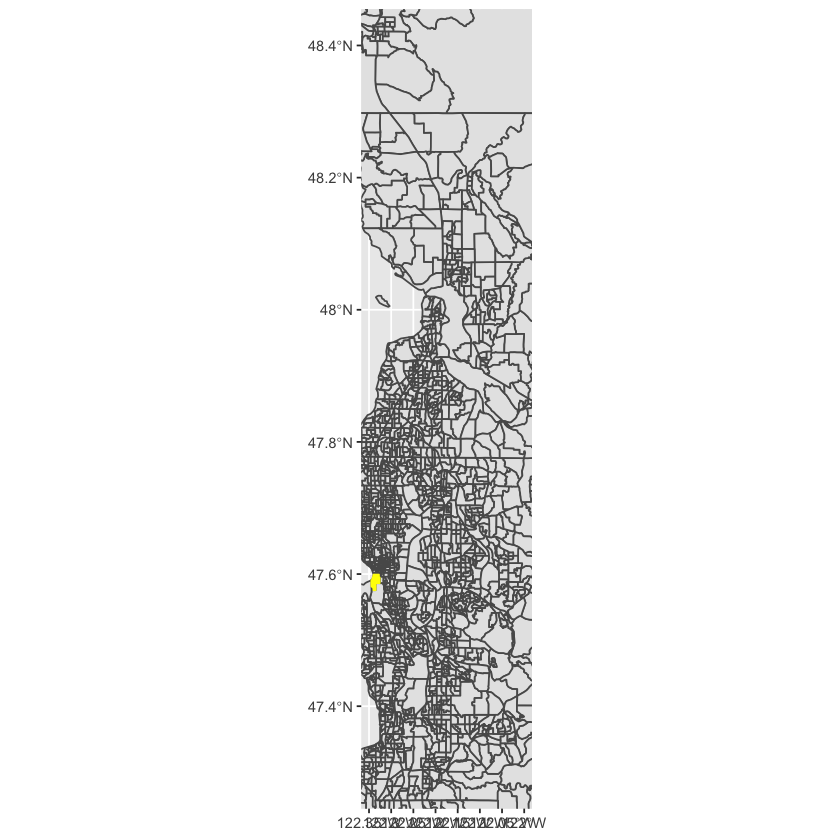

In [5]:
library(sf)
washdot_shape <- read_sf("../../data/shapefiles/roads500k/sr500k_20181231.shp")
washdot_shape <- washdot_shape[grep("405", washdot_shape$RouteID), ]
washdot_shape <- st_transform(washdot_shape, crs = 4326)

suppressWarnings(fips_shape <- read_sf(dsn = "../../data/shapefiles/block_groups/block_groups.shp"))

fips_id <- fips_shape %>%
    filter(fips_code == 530330093002)

ggplot() + 
    geom_sf(data = fips_shape) +
    geom_sf(data = fips_id, color = "yellow", fill = "yellow") +
    coord_sf(xlim=c(-122.35, -122), ylim=c(48.4, 47.3)) +
    scale_color_viridis_c()

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

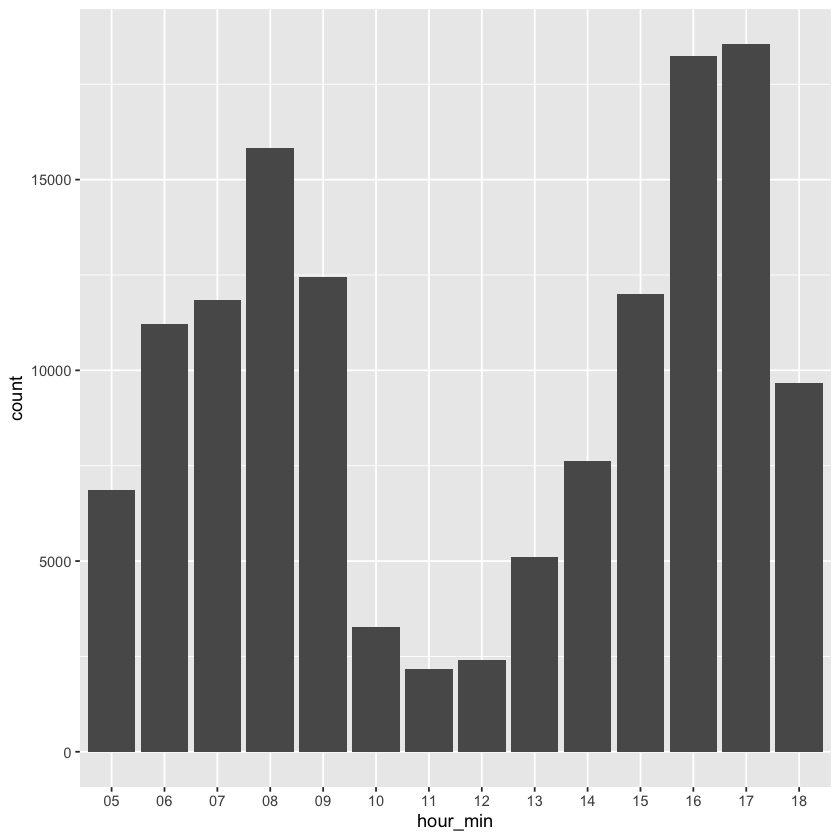

In [6]:
high_fips <- trips_linked %>%
    filter(fips == 530330093002) %>%
    execute

high_fips$entry_time <- as_datetime(high_fips$entry_time, tz = "UTC")
high_fips$hour_min <- format(as.POSIXct(high_fips$entry_time),"%H")

ggplot(high_fips, aes(x = hour_min)) +
    geom_histogram(stat = "count")

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

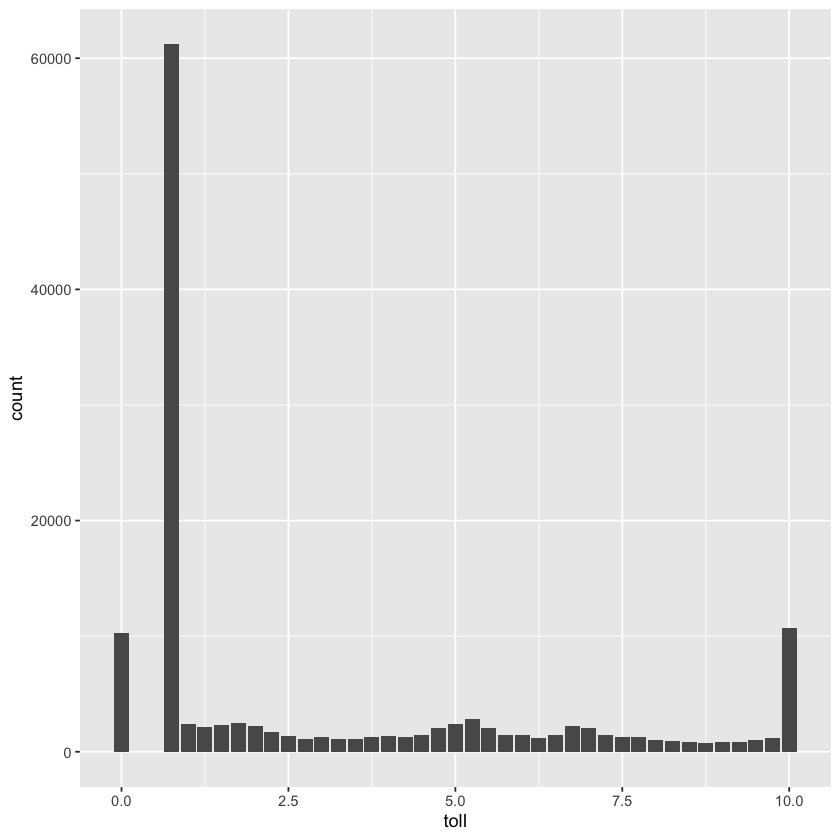

In [7]:
high_fips %>%
    filter() %>%
ggplot(aes(x = toll)) +
    geom_histogram(stat = "count")

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Removed 11886 rows containing non-finite values (stat_count).”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Removed 1 rows containing missing values (position_stack).”

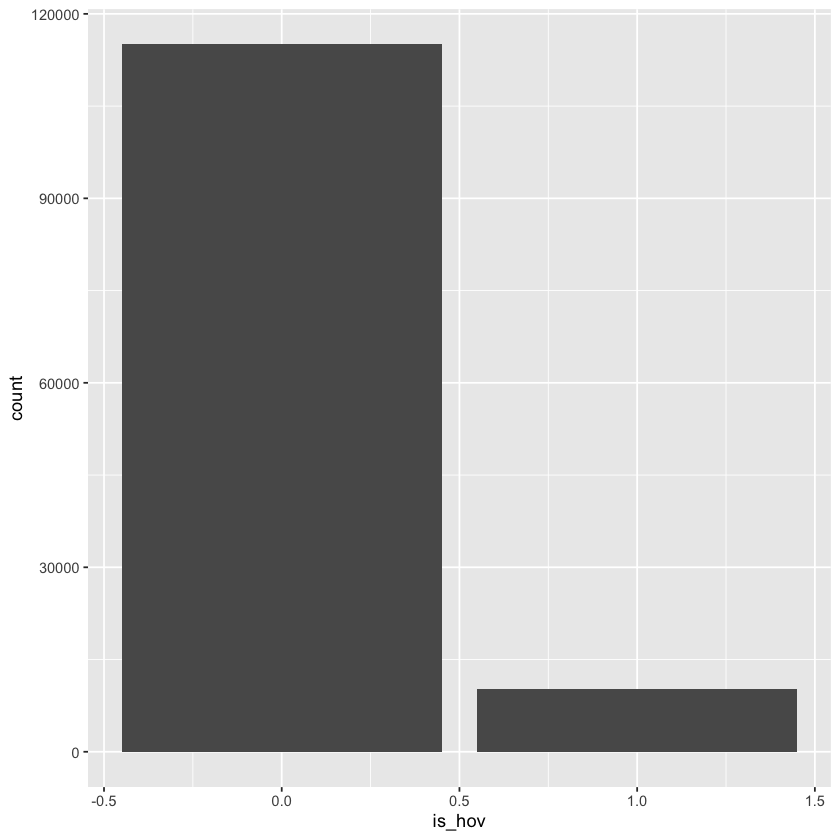

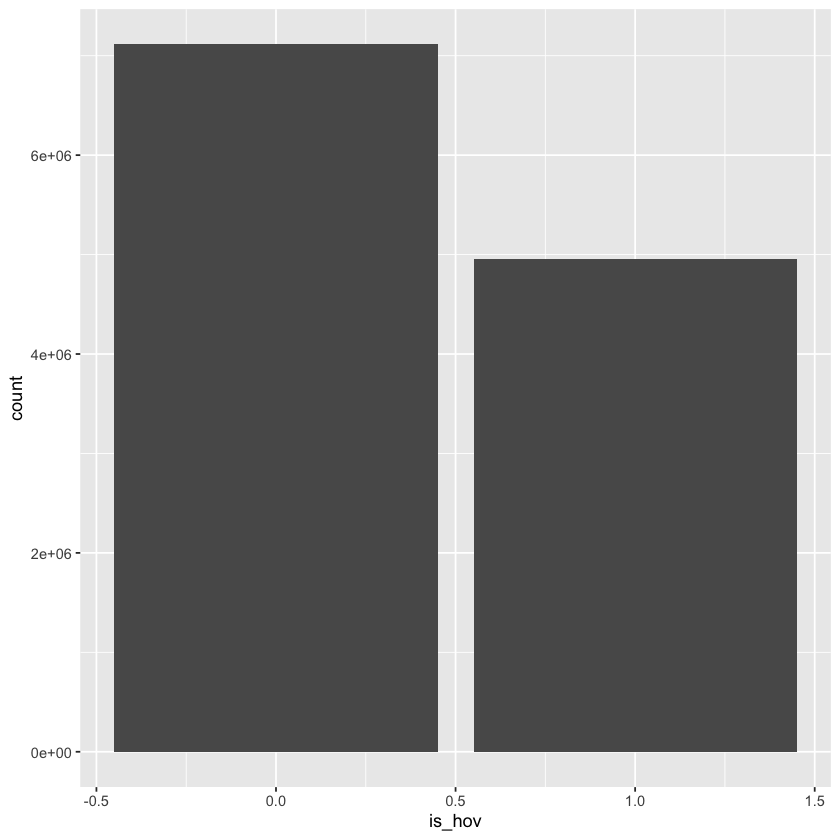

In [8]:
high_fips %>%
    filter() %>%
ggplot(aes(x = is_hov)) +
    geom_histogram(stat = "count")

trips_linked %>%
    group_by(is_hov) %>%
    summarize(count = n()) %>%
    execute %>%
ggplot(aes(x = is_hov, y = count)) +
    geom_histogram(stat = "identity")

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

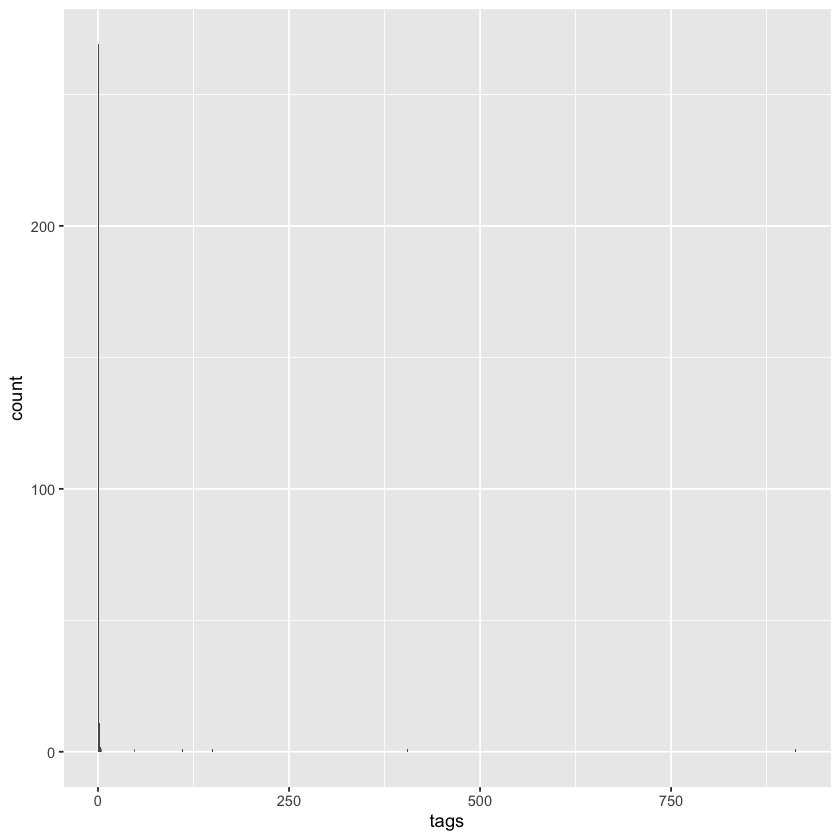

In [9]:
high_fips %>%
    group_by(id) %>%
    summarize(tags = n_distinct(tag_id)) %>%
ggplot(aes(x = tags)) +
    geom_histogram(stat = "count", bins = 10)

## High Freq Individuals

In [10]:
high_freq <- trips_2pct %>%
    filter(id != "",
          commercial ==0) %>%
    group_by(id) %>%
    summarize(tags = n_distinct(tag_id),
             trips = n()) %>%
    filter(tags < 6) %>%
    arrange(desc(trips)) %>%
    execute 

print(high_freq$id[1])

[1] -3.384025e+18


In [11]:
individual_check <- function(id_check) {
    high_id <- trips_linked %>%
    filter(as.numeric(id) == id_check) %>%
    execute
    
    print(high_id %>%
        summarize(tags = n_distinct(tag_id),
                 trips = n()) %>%
        head())
    
    high_id$entry_time <- as_datetime(high_id$entry_time, tz = "UTC")
    high_id$hour_min <- format(as.POSIXct(high_id$entry_time),"%H%M")

    print(ggplot(high_id, aes(x = hour_min)) +
        geom_histogram(stat = "count"))
    
    print(high_id %>%
    ggplot(aes(x = is_hov)) +
        geom_histogram(stat = "count"))
    
    print(high_id %>%
    ggplot(aes(x = toll)) +
        geom_histogram(stat = "count"))
    
    print(high_id %>%
          filter(toll > .75) %>%
    ggplot(aes(x = toll)) +
        geom_histogram(stat = "count"))
    
    
    print(high_id %>%
    ggplot(aes(x = entry_plaza)) +
        geom_histogram(stat = "count"))
}

As identified by the SQL query, I began looking into really high frequency travelers

# A tibble: 1 x 2
   tags trips
  <int> <int>
1     1 10604


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

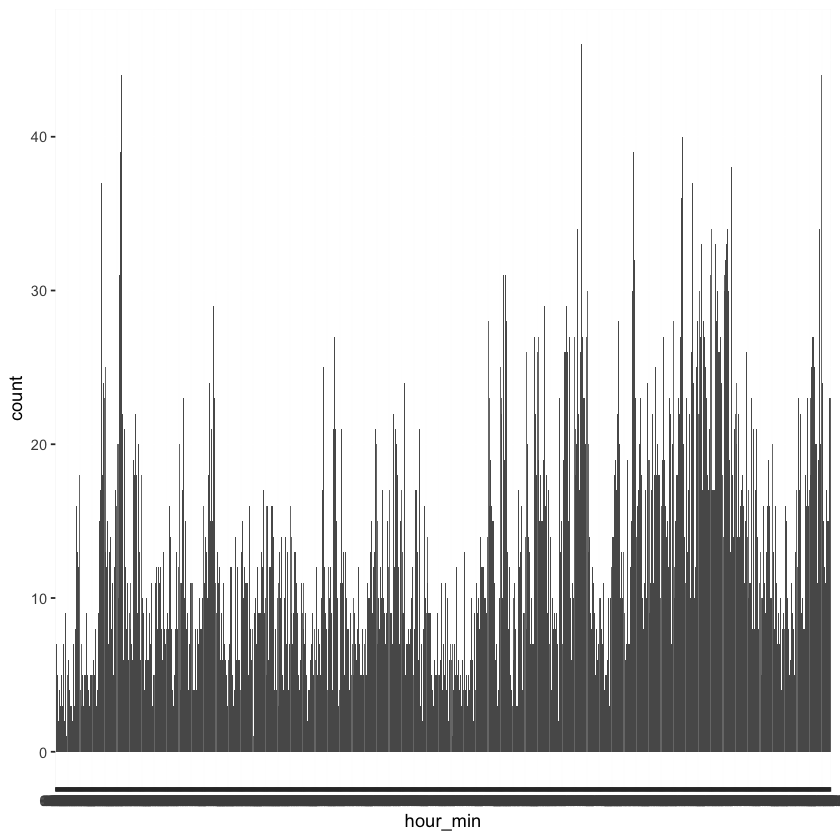

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

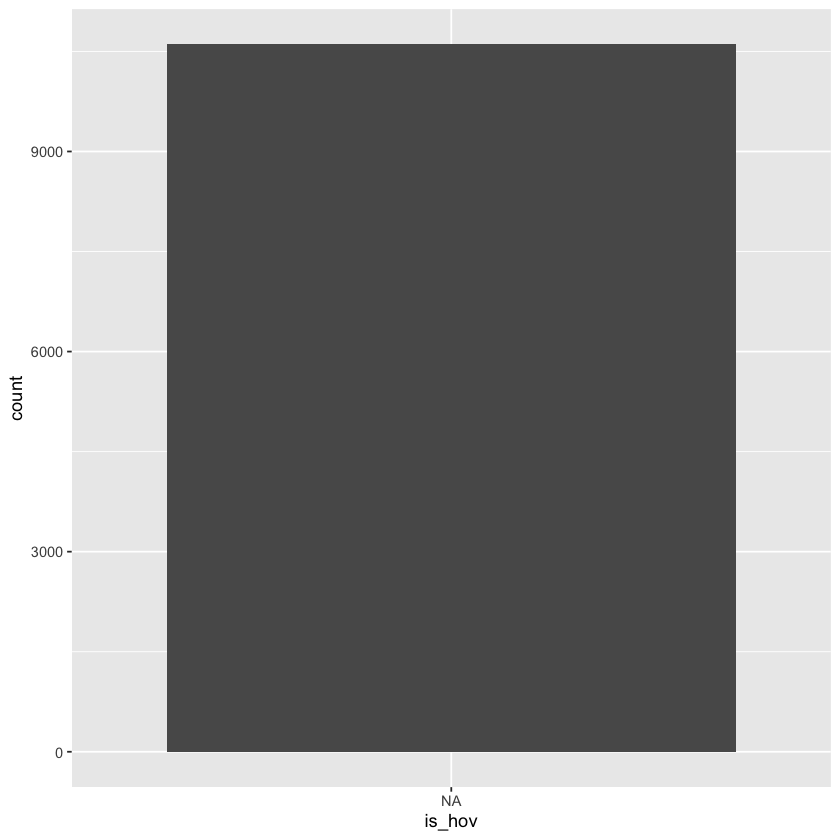

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

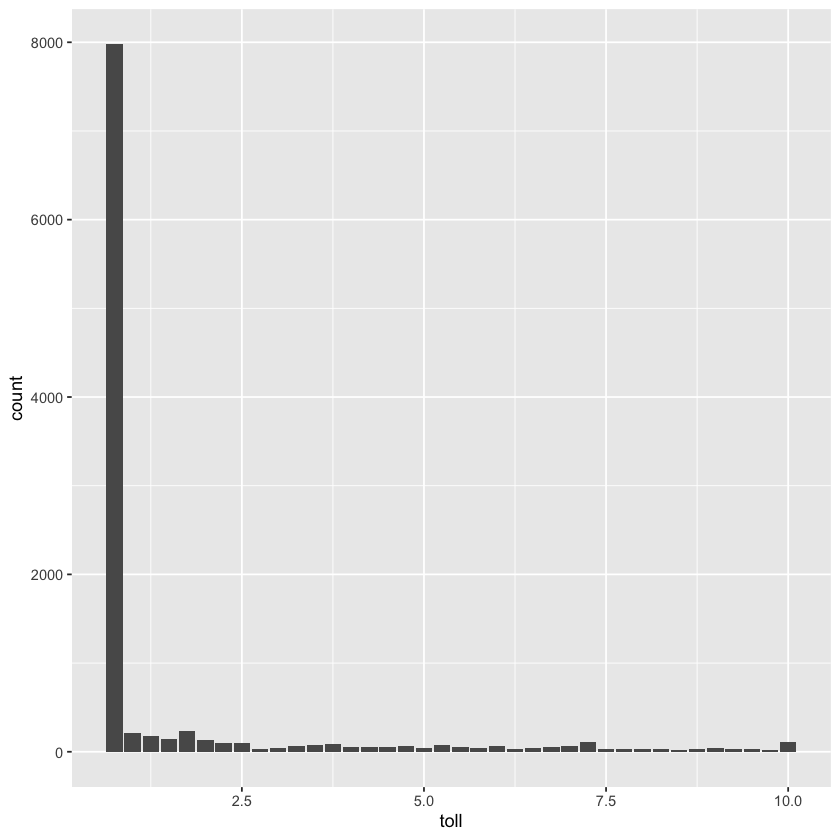

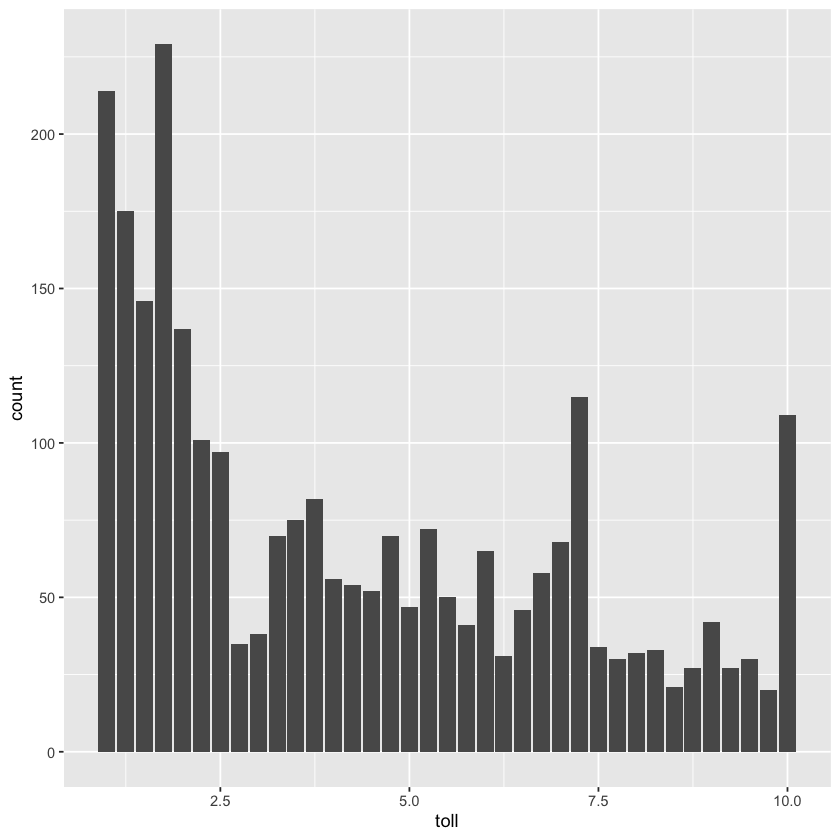

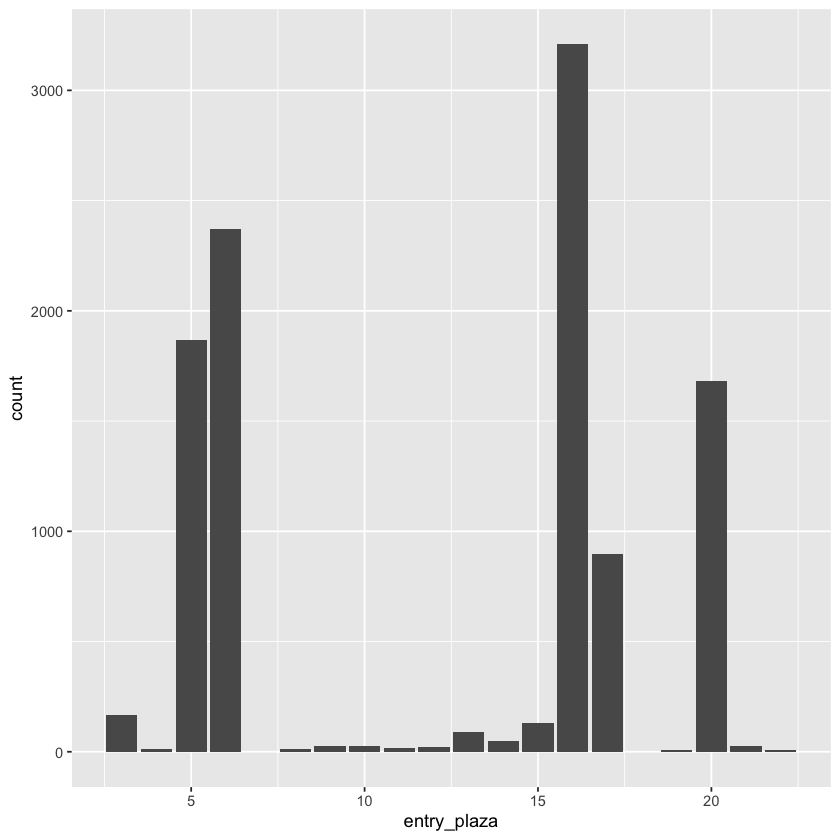

In [12]:
individual_check(-3384025460270323568)

# A tibble: 1 x 2
   tags trips
  <int> <int>
1     2  4145


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Removed 4001 rows containing non-finite values (stat_count).”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

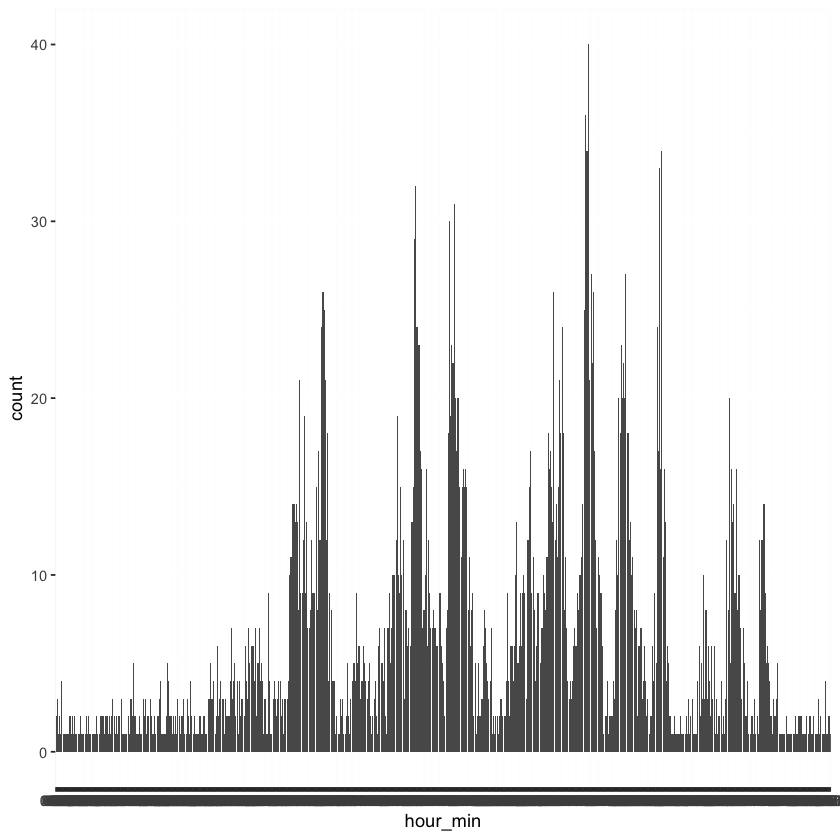

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

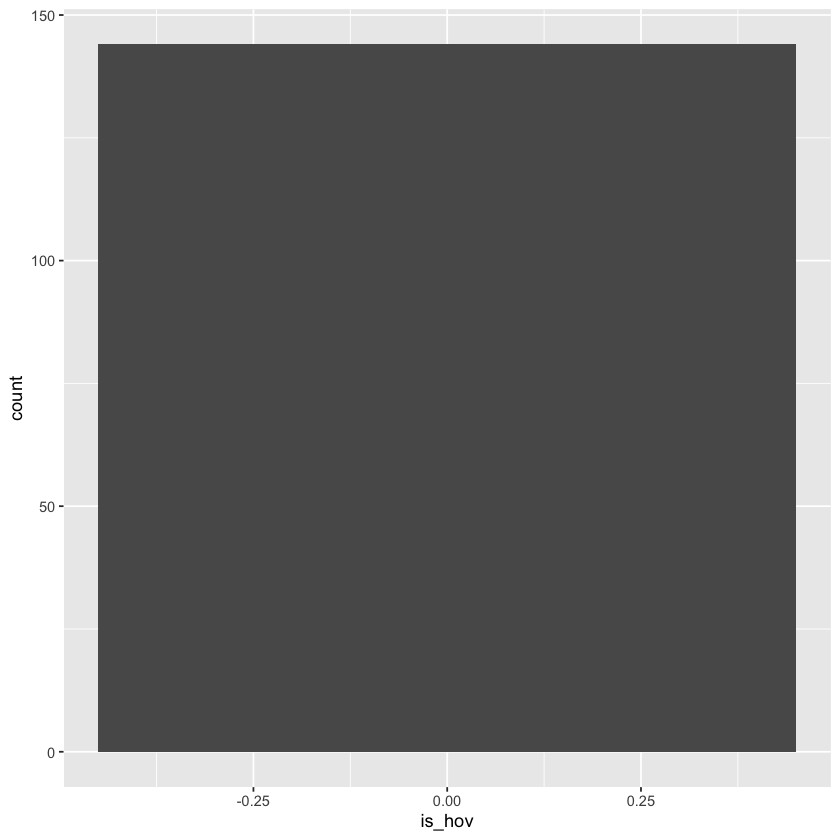

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

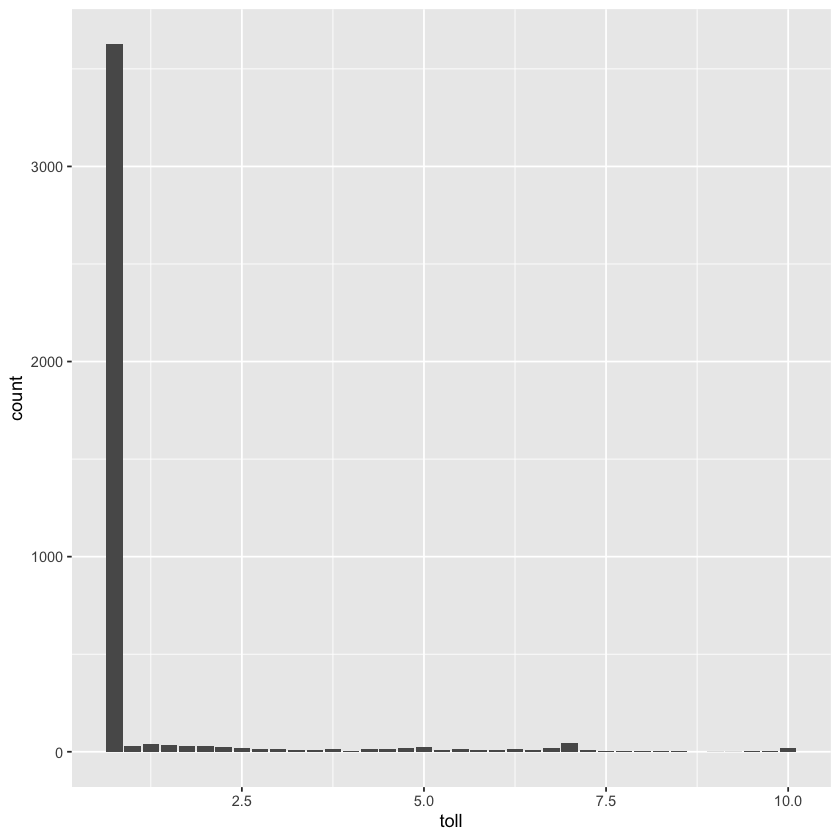

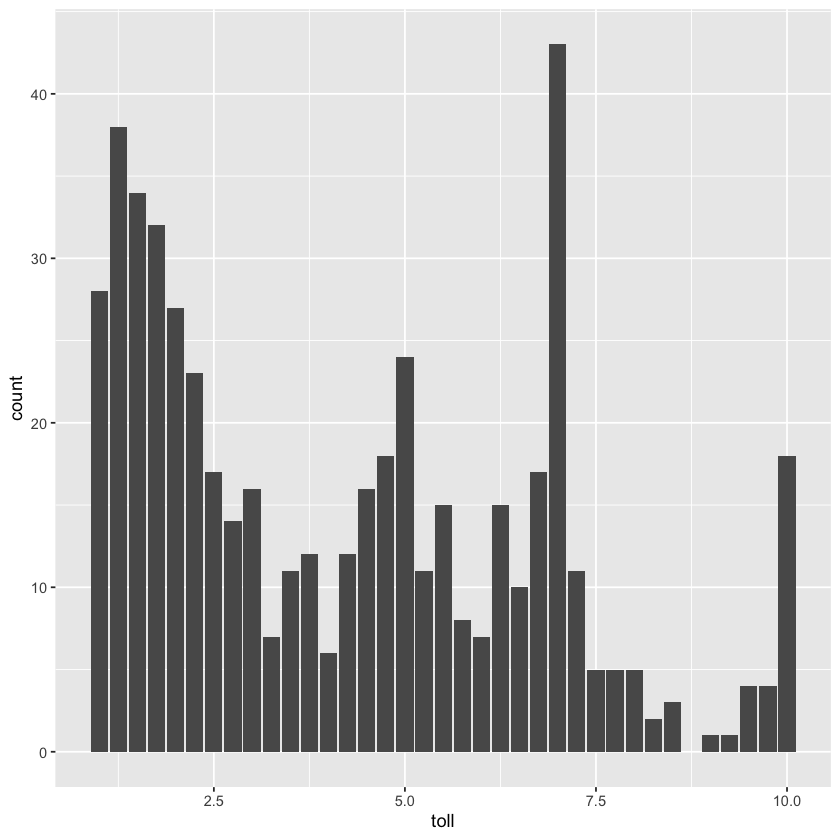

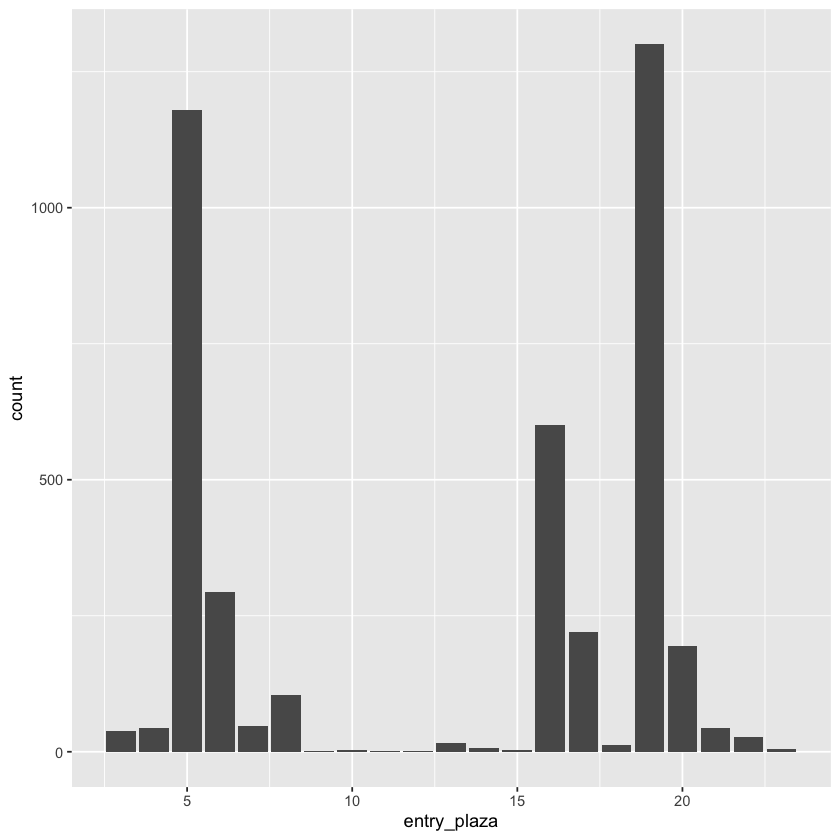

In [13]:
individual_check(-3307854826256095762)

# A tibble: 1 x 2
   tags trips
  <int> <int>
1     3  3240


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”Warning message:
“Removed 3230 rows containing non-finite values (stat_count).”Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

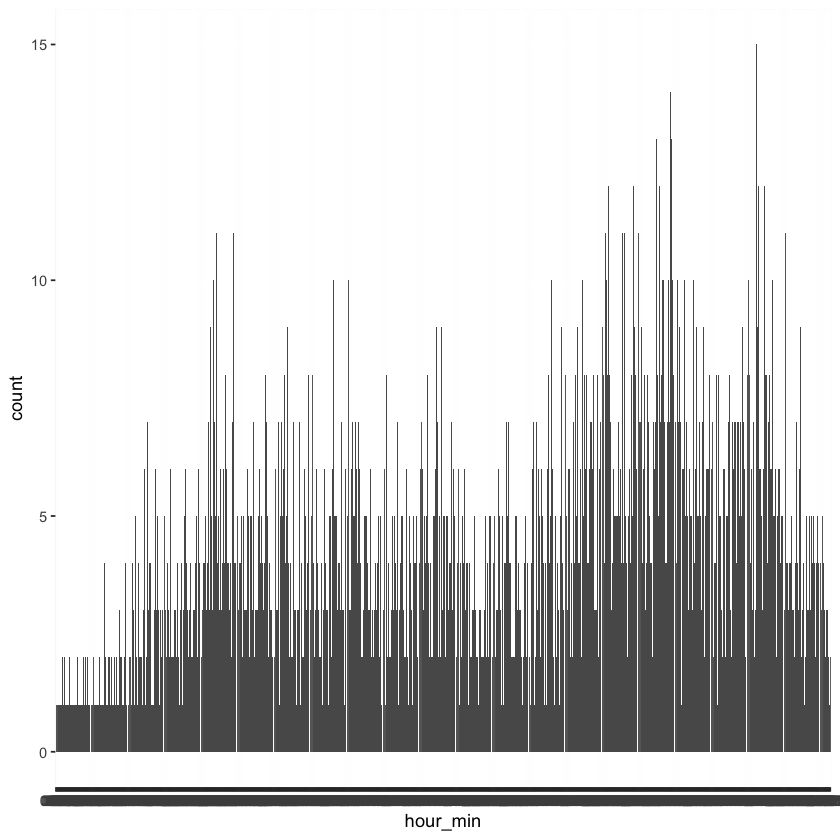

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

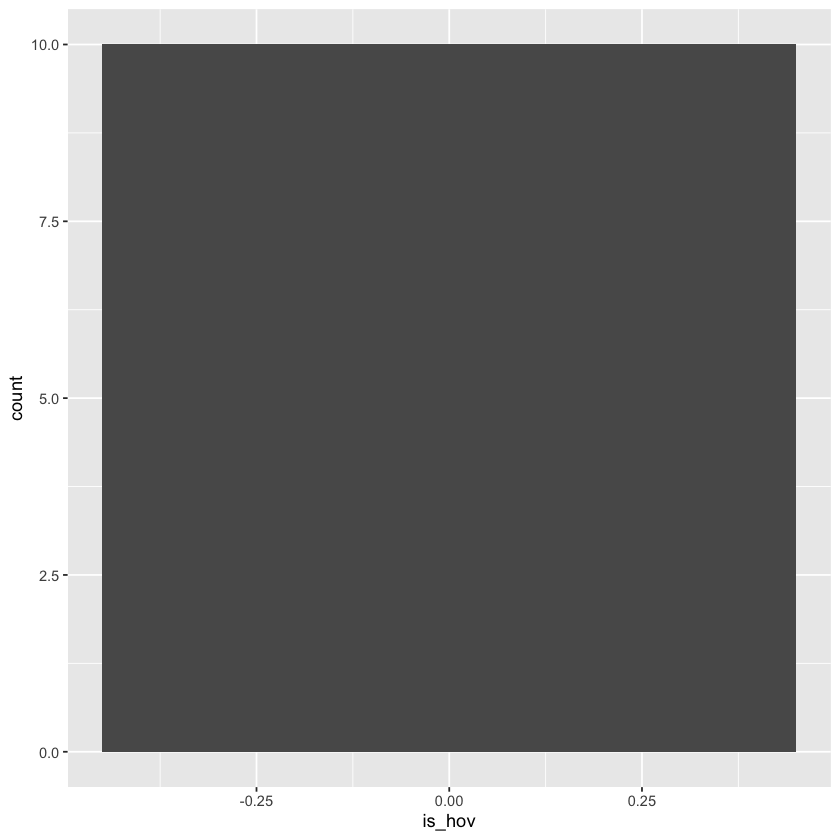

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

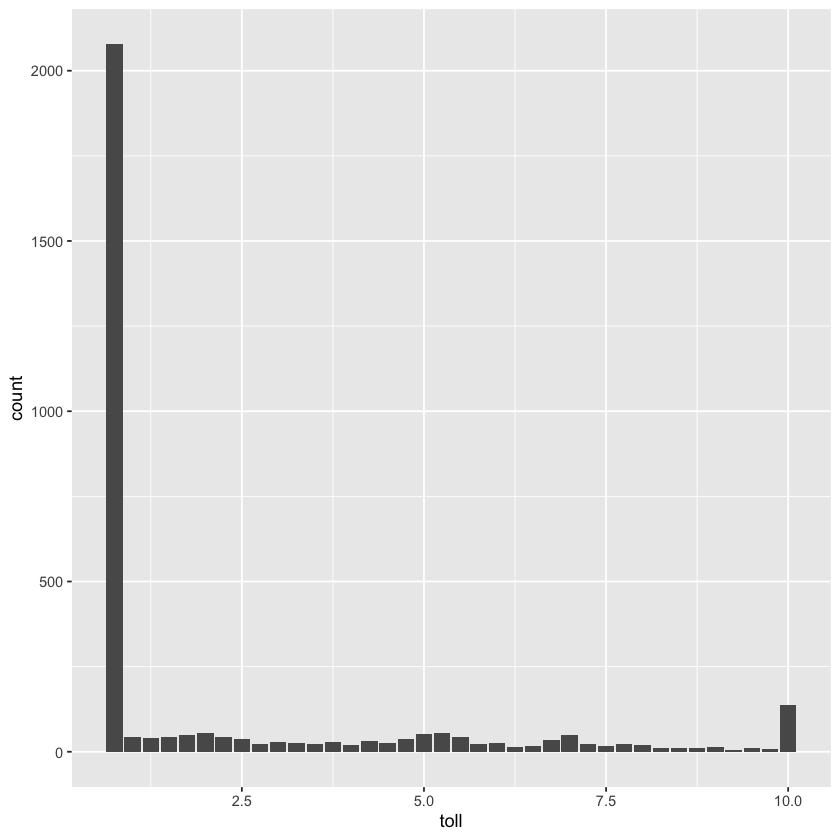

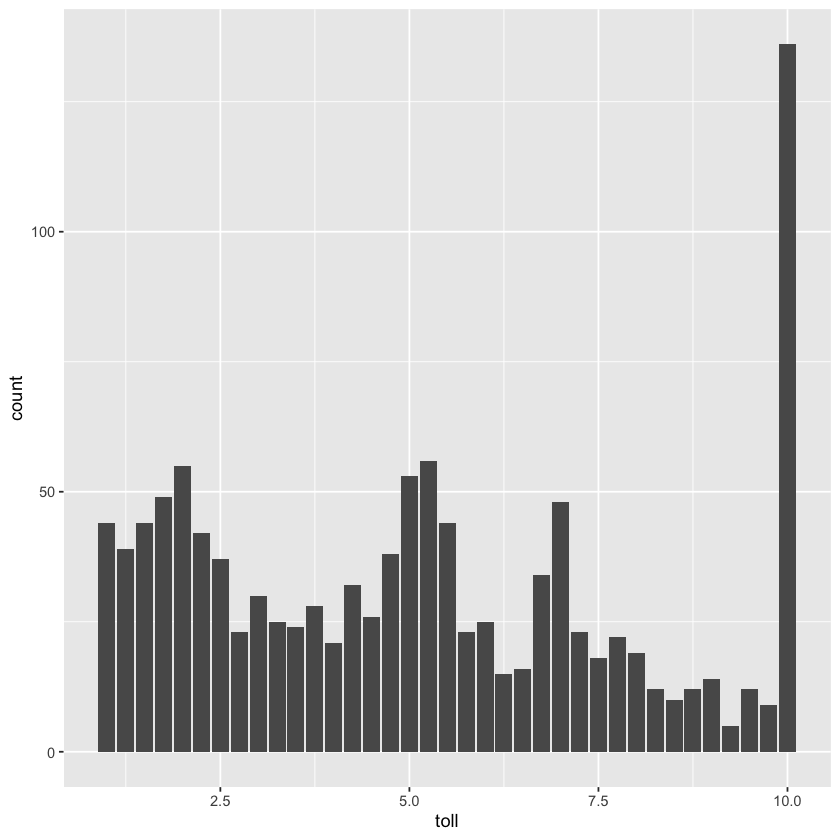

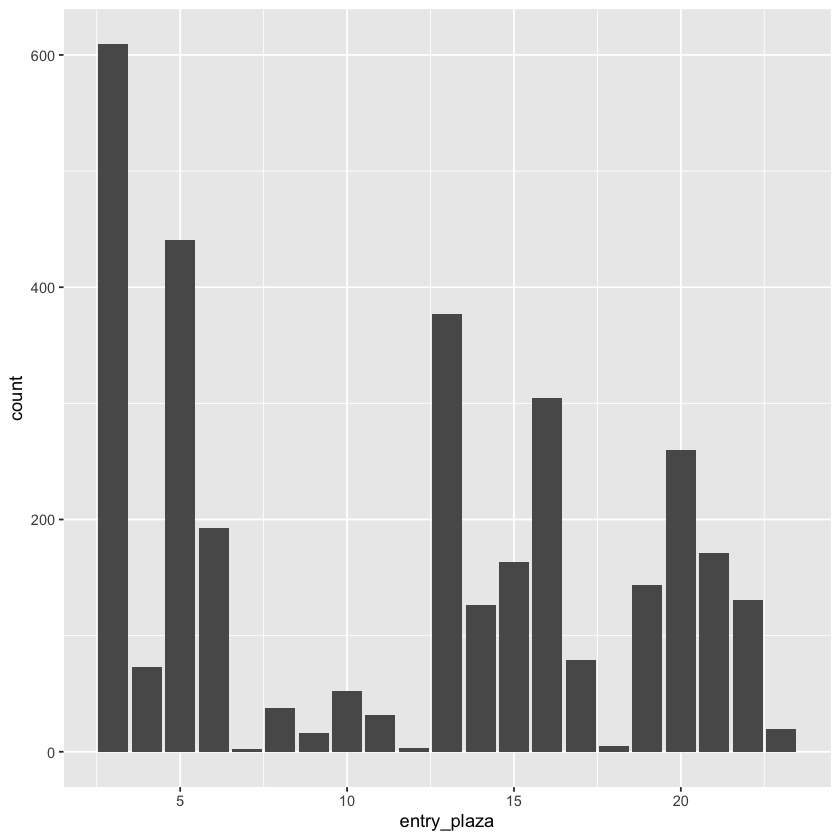

In [14]:
individual_check(-5742265347381933878)

In [15]:
trips_linked %>%
    group_by(is_hov) %>%
    summarize(count = n())%>%
    execute

is_hov,count
<dbl>,<dbl>
NA,4903775
0,7112694
1,4959665


In [16]:
trips_linked %>%
    group_by(is_hov) %>%
    summarize(toll = mean(toll)) %>%
    execute

Warning message:
“Missing values are always removed in SQL.
Use `mean(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

is_hov,toll
<dbl>,<dbl>
NA,2.35273585
0,2.70326402
1,0.02507271
